In [8]:
from torch.utils.data import Dataset, DataLoader# For custom data-sets
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple

n_class = 27

# a label and all meta information
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None):
        self.data      = pd.read_csv(csv_file)
        self.n_class   = n_class
        self.mode = csv_file
        
        # Add any transformations here
        self.resize_transform = transforms.Resize((256, 256))
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label = Image.open(label_name)
        #print("Img type is {}".format(type(img)))
        img = self.resize_transform(img)
        
        label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        # Normalization
        img = self.transforms(img).float()
        # Convert to tensor
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        
        return img, target, label


In [9]:
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')


train_loader = DataLoader(dataset=train_dataset, batch_size= 2, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 2, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 2, num_workers=4, shuffle=False)

In [10]:
print(len(train_dataset), type(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

4018 <class '__main__.IddDataset'>
2009
1004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3, 256, 256])


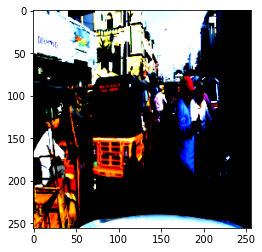

In [11]:
import matplotlib.pyplot as plt
# Print the shape of the training dataset
#print(train_dataset[0][0].shape)
# Permute the object into a different shape
train_image = train_dataset.__getitem__(0)
print(type(train_image[0]),train_image[0].shape)
tensor_image = train_image[0]
# print(type(tensor_image), tensor_image.shape)
plt.imshow(tensor_image.permute(1, 2, 0))
# plt.imshow(test_image.permute(1, 2, 0))
# plt.imshow(val_image.permute(1, 2, 0))

In [21]:
from torchvision import utils
from basic_fcn import *
#from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import pandas as pd 
from collections import defaultdict

#import pathlib

# Set up folder for model saving
# model_path = '{}/saved-models/baseline/{}/'.format(os.getcwd(), time.strftime("%Y%m%d-%H%M%S"))
# model_pathlib = pathlib.Path(model_path)
# if not model_pathlib.exists():
#     pathlib.Path(model_pathlib).mkdir(parents=True, exist_ok=True)

# First read the dataset
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')

# train_loader, val_loader and test_loader are three different sets of data
train_loader = DataLoader(dataset=train_dataset, batch_size= 2, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 2, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 2, num_workers=4, shuffle=False)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        #print("Dimension of weight = {}".format(m.weight.shape))
        #print("Dimension of bias = {}".format(m.bias.shape))
        #torch.nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs = 2       
criterion = nn.BCELoss()# Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
fcn_model = FCN(n_class=n_class)
print("No of classes = ",n_class)
fcn_model.apply(init_weights)

optimizer = optim.Adam(fcn_model.parameters(), lr=0.001)#1e-8)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    fcn_model = fcn_model.cuda()

        
def train():
    print("Reached train function")
    best_loss = float('inf')
    val_loss = []
    train_loss = []
    for epoch in range(epochs):
        train_loss_batch = []
        ts = time.time()
        print("Epoch: {}".format(epoch))
        for itera, (X, tar, Y) in enumerate(train_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            optimizer.zero_grad()
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels = tar.long()
                train_labels = tar.cuda()# Move your labels onto the gpu
            else:
                inputs, train_labels = X, tar#.long() # Unpack variables into inputs and labels

            outputs = fcn_model(inputs)
            sigmoid_func = nn.Sigmoid()
            outputs = sigmoid_func(outputs)
#             outputs = torch.argmax(outputs, 1)
#             labels = torch.argmax(labels, 1)
            #print(outputs.shape,labels.shape)
            loss = criterion(outputs, train_labels)
            train_loss_batch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if itera % 10 == 0:
                print("TRAINING: epoch{}, iter{}, loss: {}".format(epoch, itera, loss.item())) 
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        train_loss.append(np.mean(np.array(train_loss_batch)))
        curr_val_loss = val(epoch)
        val_loss.append(curr_val_loss)
        if curr_val_loss<best_loss:
            best_loss = curr_val_loss
            torch.save(fcn_model, 'best_model')
        if epoch>=5:
            stop = 0
            for i in range(0,5):
                if val_loss[epoch-i] > val_loss[epoch-i-1]:
                    stop = stop + 1
            if stop == 5 :
                print ("EarlyStop after %d epochs." % (epoch))
                return
        torch.save(fcn_model, 'last_saved_model')
        fcn_model.train()
    return train_loss, val_loss


def val(epoch):
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    fcn_model.eval() # Don't forget to put in eval mode !
    val_loss = []
    val_iou = []
    val_acc = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                val_labels = tar.cuda()# Move your labels onto the gpu
            else:
                inputs, val_labels = X, tar#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            #outputs = torch.argmax(outputs, 1)
            #labels = torch.argmax(labels, 1)
            #print(outputs.shape,labels.shape)
            sigmoid_func = nn.Sigmoid()
            loss = criterion(sigmoid_func(outputs), val_labels)
            val_loss.append(loss.item())
            if itera % 10 == 0:
                print("VALIDATION: iter{}, loss: {}".format(itera, loss.item()))
            softmax_func = torch.nn.Softmax()
            predictions = softmax_func(outputs)
            # create one-hot encoding
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,Y)
            
            val_iou.append(avg_iou)
            #print("Val acc = ",pixel_acc(predictions,Y))
            val_acc.append(pixel_acc(predictions,Y))
            #TODO: pass pred_one_hot,labels_one_hot for accuracy and iou calculations
        #print("Last itera's inputs : ",inputs)    
        val_loss = val_loss[:-1]
        val_iou = val_iou[:-1]
        val_acc = val_acc[:-1]
        avg_loss = np.mean(np.asarray(val_loss))
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        print("Validation epoch {}: avg_iou = {}, avg_acc = {}".format(epoch,avg_iou,avg_acc))
        return avg_loss   
    
def test():
    fcn_model = torch.load('best_model')
    fcn_model.eval()
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    val_iou = []
    val_acc = []
    val_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                test_labels = tar.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X, tar#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            #outputs = torch.argmax(outputs, 1)
            #labels = torch.argmax(labels, 1)
            #print(outputs.shape,labels.shape)
            softmax_func = torch.nn.Softmax()
            predictions = softmax_func(outputs)
            # create one-hot encoding
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,Y)
            val_ious_cls.append(iou_row)
            val_iou.append(avg_iou)
            val_acc.append(pixel_acc(predictions,Y))
        val_loss = val_loss[:-1]
        val_iou = val_iou[:-1]
        val_acc = val_acc[:-1]
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        avg_ious_cls = np.mean(np.asarray(val_ious_cls),axis=0)
        print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print(" Class wise ious getting saved in Baseline_IOU_Classwise.csv file")
        
        d = []
        for label in labels:
             d.append((label.name, avg_ious_cls[label.level3Id]))
        df = pd.DataFrame(d, columns=('Label name', 'IoU'))
        df.to_csv('Baseline_IOU_Classwise.csv', sep='\t')
        
        test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=4, shuffle=False)
        for itera, (X, tar, Y) in enumerate(test_loader):
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                test_labels = tar.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X, tar#.long() # Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            softmax_func = torch.nn.Softmax()
            predictions = softmax_func(outputs)
            predictions = torch.argmax(predictions,dim=1)
            break
        predictions = predictions.cpu().numpy()
        inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
        plt.imshow(inputImage, cmap='gray')
        plt.show()
        rows, cols = predictions.shape[1], predictions.shape[2]
        #print(labels)
        new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
        for row in range(rows):
            for col in range(cols):
                idx = int(predictions[0][row][col])
                new_predictions[row][col][:] = np.asarray(labels[idx].color)       

        plt.imshow(inputImage, cmap='gray')
        plt.imshow(new_predictions, cmap='jet', alpha=0.5)
        fig_name = "Overlayed_baseline.jpg"  
        plt.savefig(fig_name)
        plt.show()


No of classes =  27
Using GPU


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [16]:
a = [1,2,3,4,5]
a[:-1]

[1, 2, 3, 4]

In [13]:
def plot_loss_curves(train_loss,val_loss):
    title = "Loss "
    fig_name = "Loss_baseline.jpg"
    x = [i for i in range(len(train_loss))]
    plt.plot(x, train_loss,label="Train Loss")
    plt.plot(x, val_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("# of epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(title)
    plt.savefig(fig_name)
    plt.show()

In [14]:
#val(0)  # show the accuracy before training
train_loss, val_loss = train()

Reached train function
Epoch: 0
TRAINING: epoch0, iter0, loss: 0.8118785619735718
TRAINING: epoch0, iter10, loss: 0.7052351832389832
TRAINING: epoch0, iter20, loss: 0.6837071776390076
TRAINING: epoch0, iter30, loss: 0.6689379811286926
TRAINING: epoch0, iter40, loss: 0.6515433192253113
TRAINING: epoch0, iter50, loss: 0.6338261365890503
TRAINING: epoch0, iter60, loss: 0.610114336013794
TRAINING: epoch0, iter70, loss: 0.5792368054389954
TRAINING: epoch0, iter80, loss: 0.5511152744293213
TRAINING: epoch0, iter90, loss: 0.524856686592102
TRAINING: epoch0, iter100, loss: 0.4752606153488159
TRAINING: epoch0, iter110, loss: 0.4282166063785553
TRAINING: epoch0, iter120, loss: 0.39153149724006653
TRAINING: epoch0, iter130, loss: 0.350424587726593
TRAINING: epoch0, iter140, loss: 0.3459978699684143
TRAINING: epoch0, iter150, loss: 0.3072013556957245
TRAINING: epoch0, iter160, loss: 0.25763311982154846
TRAINING: epoch0, iter170, loss: 0.2297821342945099
TRAINING: epoch0, iter180, loss: 0.207836449

TRAINING: epoch0, iter1540, loss: 0.05165845900774002
TRAINING: epoch0, iter1550, loss: 0.09135693311691284
TRAINING: epoch0, iter1560, loss: 0.08345331996679306
TRAINING: epoch0, iter1570, loss: 0.06522004306316376
TRAINING: epoch0, iter1580, loss: 0.04792574420571327
TRAINING: epoch0, iter1590, loss: 0.07607451826334
TRAINING: epoch0, iter1600, loss: 0.05501370504498482
TRAINING: epoch0, iter1610, loss: 0.0734299048781395
TRAINING: epoch0, iter1620, loss: 0.07052215933799744
TRAINING: epoch0, iter1630, loss: 0.06324795633554459
TRAINING: epoch0, iter1640, loss: 0.05478823184967041
TRAINING: epoch0, iter1650, loss: 0.06987770646810532
TRAINING: epoch0, iter1660, loss: 0.08664298057556152
TRAINING: epoch0, iter1670, loss: 0.08550859242677689
TRAINING: epoch0, iter1680, loss: 0.06626023352146149
TRAINING: epoch0, iter1690, loss: 0.07282809913158417
TRAINING: epoch0, iter1700, loss: 0.06939683854579926
TRAINING: epoch0, iter1710, loss: 0.05389914661645889
TRAINING: epoch0, iter1720, loss

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Val acc =  0.1464434276947297
Val acc =  0.1575299095743503
Val acc =  0.1324249244573529
Val acc =  0.1297667192586101
Val acc =  0.1406535814522813
Val acc =  0.14771342911302351
Val acc =  0.1581085340095663
Val acc =  0.12586504423477374
VALIDATION: iter10, loss: 0.09529820084571838
Val acc =  0.1058624445898688
Val acc =  0.11081830263129246
Val acc =  0.13831293777513368
Val acc =  0.1583132083584527
Val acc =  0.12315977391126195
Val acc =  0.14378641425914165
Val acc =  0.1262877623428102
Val acc =  0.1455971789324311
Val acc =  0.1390105611738058
Val acc =  0.13085946297490217
VALIDATION: iter20, loss: 0.05699998885393143
Val acc =  0.10576062415831214
Val acc =  0.12964762065458532
Val acc =  0.1712621875913087
Val acc =  0.14205372906533448
Val acc =  0.12404398477717249
Val acc =  0.16652967890802128
Val acc =  0.1147305392351166
Val acc =  0.14283203889069893
Val acc =  0.1407155165730164
Val acc =  0.09507073282681697
VALIDATION: iter30, loss: 0.05428040400147438
Val acc 

Val acc =  0.0982592086834706
Val acc =  0.11575308515841005
Val acc =  0.16142006856829486
Val acc =  0.1651277412079617
Val acc =  0.17504431530969736
Val acc =  0.09498587714034513
VALIDATION: iter240, loss: 0.07941535860300064
Val acc =  0.14403111066757773
Val acc =  0.11051138830061959
Val acc =  0.15474646333614445
Val acc =  0.10782590879000242
Val acc =  0.13021674581567005
Val acc =  0.1618658789941355
Val acc =  0.12701011030787712
Val acc =  0.12140335817625199
Val acc =  0.14363503194097696
Val acc =  0.12935113009481933
VALIDATION: iter250, loss: 0.059081707149744034
Val acc =  0.17960882640346704
Val acc =  0.12233648083339362
Val acc =  0.13931267435646447
Val acc =  0.1450385207516884
Val acc =  0.14088168460872733
Val acc =  0.16959689301792621
Val acc =  0.11119440108364895
Val acc =  0.18627914034334303
Val acc =  0.12692110702820208
Val acc =  0.14937596685399804
VALIDATION: iter260, loss: 0.05955900996923447
Val acc =  0.15065331424283357
Val acc =  0.136569756915

Val acc =  0.134023066508694
Val acc =  0.16600721943871458
Val acc =  0.12687237043317068
Val acc =  0.10029659103208309
Val acc =  0.035275119893236964
VALIDATION: iter470, loss: 0.05838557705283165
Val acc =  0.09108683381608364
Val acc =  0.14698422305367562
Val acc =  0.12100623011340728
Val acc =  0.137379392060635
Val acc =  0.12495196618366965
Val acc =  0.14784635675219682
Val acc =  0.13670639401024098
Val acc =  0.17454603395912024
Val acc =  0.1812897563908986
Val acc =  0.11781839706644384
VALIDATION: iter480, loss: 0.09167107194662094
Val acc =  0.11642566755687282
Val acc =  0.14165336200921913
Val acc =  0.1384109452840339
Val acc =  0.10569656468329125
Val acc =  0.1304038462401607
Val acc =  0.14545036420872315
Val acc =  0.16703279976748836
Val acc =  0.12939449549894652
Val acc =  0.11428102077611282
Val acc =  0.12773785499866894
VALIDATION: iter490, loss: 0.05728709325194359
Val acc =  0.14480989345671721
Val acc =  0.13464414625132262
Val acc =  0.138339968517336

Val acc =  0.09544769033632416
Val acc =  0.13365550276268998
Val acc =  0.1558963573712136
VALIDATION: iter700, loss: 0.09082493931055069
Val acc =  0.11333288996688116
Val acc =  0.1610481620292456
Val acc =  0.13429114336635717
Val acc =  0.11321403201049852
Val acc =  0.11905189214649209
Val acc =  0.09516470967083622
Val acc =  0.13418962913993718
Val acc =  0.1572836279657915
Val acc =  0.1160911146226665
Val acc =  0.12843904190221556
VALIDATION: iter710, loss: 0.061704155057668686
Val acc =  0.06966103410441778
Val acc =  0.1575669797595211
Val acc =  0.13255253562470762
Val acc =  0.1438735346064755
Val acc =  0.09511315736874236
Val acc =  0.14298584031938735
Val acc =  0.15086223385022737
Val acc =  0.18267871231659416
Val acc =  0.13729815168008253
Val acc =  0.1645804401334462
VALIDATION: iter720, loss: 0.07117883116006851
Val acc =  0.12047662931702338
Val acc =  0.1366574897729632
Val acc =  0.13288888090275056
Val acc =  0.1134925006470186
Val acc =  0.14210731289675463

Val acc =  0.17380795488564316
VALIDATION: iter930, loss: 0.07015417516231537
Val acc =  0.1608459200568476
Val acc =  0.16633877640932665
Val acc =  0.11761452126701463
Val acc =  0.13334309587192955
Val acc =  0.15911145314513103
Val acc =  0.15149905078662212
Val acc =  0.12106847573899897
Val acc =  0.10565121677137468
Val acc =  0.12892649120641003
Val acc =  0.13105306414768803
VALIDATION: iter940, loss: 0.06017504632472992
Val acc =  0.1253252125466032
Val acc =  0.11424613846593722
Val acc =  0.13672478129029705
Val acc =  0.18063024597700397
Val acc =  0.15154582110573098
Val acc =  0.155038355837867
Val acc =  0.11858808345644434
Val acc =  0.15291587434956602
Val acc =  0.10748745460981134
Val acc =  0.1177552258031757
VALIDATION: iter950, loss: 0.0528593547642231
Val acc =  0.12558614591646333
Val acc =  0.12921749326685722
Val acc =  0.16872862828321086
Val acc =  0.11949327689031505
Val acc =  0.10664028455090414
Val acc =  0.14664702254116666
Val acc =  0.146892747697518

TRAINING: epoch1, iter1030, loss: 0.05250917002558708
TRAINING: epoch1, iter1040, loss: 0.07300828397274017
TRAINING: epoch1, iter1050, loss: 0.061002325266599655
TRAINING: epoch1, iter1060, loss: 0.052333708852529526
TRAINING: epoch1, iter1070, loss: 0.07555368542671204
TRAINING: epoch1, iter1080, loss: 0.06924181431531906
TRAINING: epoch1, iter1090, loss: 0.07040783762931824
TRAINING: epoch1, iter1100, loss: 0.02519988641142845
TRAINING: epoch1, iter1110, loss: 0.0465988889336586
TRAINING: epoch1, iter1120, loss: 0.06619471311569214
TRAINING: epoch1, iter1130, loss: 0.06912735849618912
TRAINING: epoch1, iter1140, loss: 0.05985039845108986
TRAINING: epoch1, iter1150, loss: 0.05670928582549095
TRAINING: epoch1, iter1160, loss: 0.07028437405824661
TRAINING: epoch1, iter1170, loss: 0.05169810727238655
TRAINING: epoch1, iter1180, loss: 0.055648017674684525
TRAINING: epoch1, iter1190, loss: 0.05114858224987984
TRAINING: epoch1, iter1200, loss: 0.04444437101483345
TRAINING: epoch1, iter1210

Val acc =  0.15858036575922974
Val acc =  0.18936250913631658
Val acc =  0.12869728984923728
Val acc =  0.12518547998802165
Val acc =  0.10886395700725673
Val acc =  0.12234341612816939
Val acc =  0.14122052983239652
Val acc =  0.13282035903317427
Val acc =  0.07236350091419433
Val acc =  0.13683293758687395
VALIDATION: iter90, loss: 0.054346222430467606
Val acc =  0.137989983772831
Val acc =  0.1075133451147812
Val acc =  0.11608939604611673
Val acc =  0.1457436227050539
Val acc =  0.11906469608395269
Val acc =  0.1165744052395257
Val acc =  0.1866750642596699
Val acc =  0.14406695402643246
Val acc =  0.12968939060304455
Val acc =  0.15732447732460852
VALIDATION: iter100, loss: 0.054688263684511185
Val acc =  0.1425862843899877
Val acc =  0.15917631524084191
Val acc =  0.1707602448216043
Val acc =  0.12268343614164336
Val acc =  0.14913394062482055
Val acc =  0.18129417451979002
Val acc =  0.1413682761269509
Val acc =  0.12448483929813772
Val acc =  0.15223011975966655
Val acc =  0.12

Val acc =  0.13855628680339305
Val acc =  0.19406921333807312
Val acc =  0.14690829163185778
Val acc =  0.12678918318177534
Val acc =  0.10434465674120705
Val acc =  0.15257521605132288
Val acc =  0.1323556704049679
Val acc =  0.1575431571436826
VALIDATION: iter320, loss: 0.05958206206560135
Val acc =  0.15450512704977218
Val acc =  0.1880215023758142
Val acc =  0.18155737342057443
Val acc =  0.10549510268853703
Val acc =  0.17643684343234914
Val acc =  0.1558881896182593
Val acc =  0.1673717743771671
Val acc =  0.15190185844953674
Val acc =  0.10931439949631859
Val acc =  0.18962121235785195
VALIDATION: iter330, loss: 0.06751509755849838
Val acc =  0.17159275495103957
Val acc =  0.16651175400143134
Val acc =  0.160338502643614
Val acc =  0.12551484713769728
Val acc =  0.18660573278591847
Val acc =  0.11906464737530632
Val acc =  0.1922155307378151
Val acc =  0.17705315363869692
Val acc =  0.14559407324206525
Val acc =  0.18659651024905385
VALIDATION: iter340, loss: 0.07948135584592819

Val acc =  0.16526680020811801
Val acc =  0.15044684653143459
Val acc =  0.2068812198782328
Val acc =  0.15911508564140867
VALIDATION: iter550, loss: 0.04109160974621773
Val acc =  0.14619362012608642
Val acc =  0.1594062137000721
Val acc =  0.1103038051260954
Val acc =  0.14988974601469515
Val acc =  0.17544382496106667
Val acc =  0.20205000742062287
Val acc =  0.14126646222895584
Val acc =  0.14647434468784123
Val acc =  0.21491980710029318
Val acc =  0.21737757022953866
VALIDATION: iter560, loss: 0.05750499293208122
Val acc =  0.13653462262189586
Val acc =  0.1387014092880757
Val acc =  0.12324823123631166
Val acc =  0.1536226065920856
Val acc =  0.18153906395033134
Val acc =  0.14650501700063692
Val acc =  0.1608127675887736
Val acc =  0.14573184493481847
Val acc =  0.1322739900767019
Val acc =  0.12566695478433185
VALIDATION: iter570, loss: 0.0719183012843132
Val acc =  0.14365854666864897
Val acc =  0.0777776226289627
Val acc =  0.14496678826621473
Val acc =  0.11050048667451638


Val acc =  0.16774369603858244
VALIDATION: iter780, loss: 0.05131247639656067
Val acc =  0.17520258577631165
Val acc =  0.17700795526971425
Val acc =  0.13821136025071934
Val acc =  0.1576510769542626
Val acc =  0.12637687922758897
Val acc =  0.1527731880994271
Val acc =  0.15224185581747054
Val acc =  0.19368980011147904
Val acc =  0.1720487084702057
Val acc =  0.14755894986411863
VALIDATION: iter790, loss: 0.04960606247186661
Val acc =  0.17192905169014563
Val acc =  0.15885669418727463
Val acc =  0.16073224324713062
Val acc =  0.15159999055289683
Val acc =  0.12378051479674126
Val acc =  0.16677958748649319
Val acc =  0.1961978691957617
Val acc =  0.14144085981557786
Val acc =  0.15317732853912508
Val acc =  0.13535945247412393
VALIDATION: iter800, loss: 0.08416739851236343
Val acc =  0.1526348890098743
Val acc =  0.2151964720576056
Val acc =  0.161283163315916
Val acc =  0.16790808441235003
Val acc =  0.15834981446020352
Val acc =  0.11669233344526898
Val acc =  0.16908852859466372

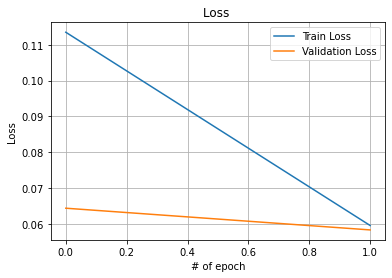

In [17]:
plot_loss_curves(train_loss,val_loss)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Final test from best model : avg_iou = 0.11709040432008506, avg_acc = nan
 Class wise ious = 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


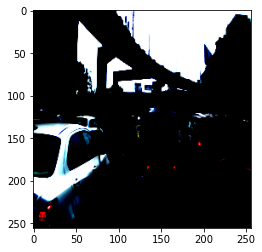

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


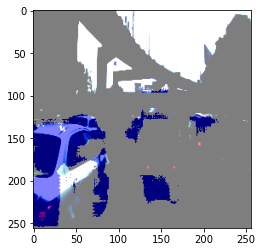

In [22]:
test()

In [ ]:
ious = [None]*25
print(len(ious))
print(ious)
ious[0] = [1,2,3]
print(ious)

In [ ]:
ious = [0,1,2,3]#[[1,3,0],[1,1,0],[2,1,1]]
#ious.append([1,0,1])
print(ious[:-1])
ious = np.array(ious)
print(np.mean(ious,axis=0))
#print(np.array(ious)[:][0:2])
# avg_iou = np.mean(np.array(ious[:][0:2])) #discarding class=26
# print(avg_iou)
# avg_iou = np.mean(avg_iou)
# print(avg_iou)

In [ ]:
print(str(labels[0].name))
#print()

In [ ]:
test_data = test_dataset[0]
print(len(test_data))
print(test_data[0].shape)
print("-------")
print(test_data[1].shape)
print(test_data[2].shape)

In [ ]:

fcn_model = torch.load('best_model')
fcn_model.eval()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    #fcn_model = fcn_model.cuda()

test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=4, shuffle=False)
for itera, (X, tar, Y) in enumerate(test_loader):
    #print("Printing the contents of X, tar and Y")
    #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
    #optimizer.zero_grad()
    if use_gpu:
        inputs = X.cuda()# Move your inputs onto the gpu
        #labels = tar.long()
        labels = tar.cuda()# Move your labels onto the gpu
    else:
        inputs, labels = X, tar#.long() # Unpack variables into inputs and labels

    outputs = fcn_model(inputs)
    softmax_func = torch.nn.Softmax()
    predictions = softmax_func(outputs)
    predictions = torch.argmax(predictions,dim=1)
    break
    
from dataloader import *

print(predictions.shape)
predictions = predictions.cpu().numpy()
inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
plt.imshow(inputImage, cmap='gray')
plt.show()
rows, cols = predictions.shape[1], predictions.shape[2]
#print(labels)
new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
for row in range(rows):
    for col in range(cols):
        idx = int(predictions[0][row][col])
        new_predictions[row][col][:] = np.asarray(labels[idx].color)       
#[[predictions[row][col] = np.asarray(labels[predictions[row][col]].color) for row in range(rows)] for col in range(cols)]
#print(new_predictions.shape)
#predictions = predictions.permute(1, 2, 0)
plt.imshow(inputImage, cmap='gray')
plt.imshow(new_predictions, cmap='jet', alpha=0.5)
fig_name = "Overlayed_baseline.jpg"  
plt.savefig(fig_name)
plt.show()
